Let's generate data according to a Zero-Inflated Probabilistic/Non-negative Count Matrix Factorization model with two clusters and check how scVI compares with an inferred ZINMF in separating the clusters. We will use `edward` for the ZINMF model. 

# Imports

In [3]:
%matplotlib inline

from scvi import scVI

import edward as ed
from edward.models import Poisson, Gamma, Bernoulli, RelaxedBernoulli, TransformedDistribution, Normal

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from benchmarking import *

plt.style.use('ggplot')

# Generating synthetic data

In [4]:
N = 500 # number of observations
M = 2 # data dimension
D = 2 # lower-dimensional space
K = 2 # number of clusters

labels = ['cell type 1', 'cell type 2']

In [5]:
# Generation of U: a matrix with block diagonal matrix with each block corresponding to a group
# Each entry in each block is drawn from a Gamma(alpha + eps, 1) and the rest are drawn from a Gamma(alpha, 1). 
# Thus, eps defines how distinct the two groups are.

alpha = 1.
eps = 5.

U_data = np.random.gamma(alpha, 1., size=(D, N))
c_data = np.zeros((N,))
K = 2
for k in range(K):
    c_data[int(k*N/K):int((k+1)*N/K)] = c_data[int(k*N/K):int((k+1)*N/K)] + k
    U_data[int(k*D/K):int((k+1)*D/K), int(k*N/K):int((k+1)*N/K)] = np.random.gamma(alpha + eps, 1., size=(int(D/K), int(N/K)))

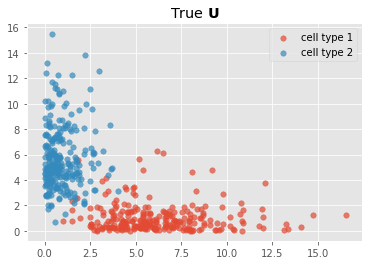

In [6]:
s = 30
alpha = 0.7

handlers = []
for k in range(K):
    h = plt.scatter(U_data[0, int(k*N/K):int((k+1)*N/K)], U_data[1, int(k*N/K):int((k+1)*N/K)], s=s, alpha=alpha)
    handlers.append(h)
    
plt.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')
plt.show()

In [7]:
# DATA
# the data contains 2 clusters, corresponding to different alphas and betas
alpha = 2.
beta = 2.
p = 0.5

# NMF
V_data = np.random.gamma(alpha, 1./beta, size=(D, M))
R_data = np.matmul(U_data.T, V_data)
X_data = np.random.poisson(R_data)

# ZI
H_data = np.random.binomial(1., p=p, size=(N, M))
Y_data = np.where(H_data == 1, np.zeros((N, M)), X_data)

In [9]:
Y_data.shape

(500, 2)

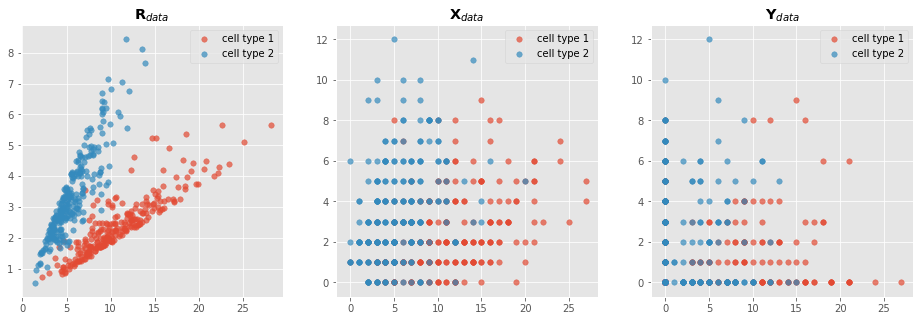

In [10]:
# Plot data
s = 30
alpha = 0.7

fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(1, 3, 1)
handlers = []
for k in range(K):
    h = ax1.scatter(R_data[int(k*N/K):int((k+1)*N/K), 0], R_data[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('$\mathbf{R}_{data}$')

ax2 = plt.subplot(1, 3, 2)
handlers = []
for k in range(K):
    h = ax2.scatter(X_data[int(k*N/K):int((k+1)*N/K), 0], X_data[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('$\mathbf{X}_{data}$')

ax3 = plt.subplot(1, 3, 3)
handlers = []
for k in range(K):
    h = ax3.scatter(Y_data[int(k*N/K):int((k+1)*N/K), 0], Y_data[int(k*N/K):int((k+1)*N/K), 1], s=s, alpha=alpha)
    handlers.append(h)
ax3.legend(handlers, labels, scatterpoints=1)
plt.title('$\mathbf{Y}_{data}$')

plt.show()

In [20]:
expression_train, expression_test, c_train, c_test = train_test_split(Y_data, c_data)

# scVI

In [21]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')

model = scVI(x, n_hidden=20)

## Tensorflow session

In [22]:
# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training

In [23]:
batch_size = 20

In [24]:
def next_batch(data, batch_size):
    index = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    return data[index].astype(np.float32)

In [25]:
def train_model(num_epochs, expression_train, expression_test):
    train_loss = []
    valid_loss = []
    
    iterep = int(expression_train.shape[0] / float(batch_size)) - 1  
    
    for t in range(iterep * num_epochs):
        # arrange data in batches
        x_train = next_batch(expression_train, batch_size)
        x_test = next_batch(expression_test, batch_size)

        #prepare data dictionaries
        dic_train = {x: x_train}
        dic_test = {x: expression_test} 
        
        # run an optimization set
        _, l_tr = sess.run([model.train_step, model.loss], feed_dict=dic_train)
        end_epoch, epoch = t % iterep == 0, t / iterep

        if end_epoch:          
            print(epoch)
            l_t = sess.run((model.loss), feed_dict=dic_test)
            
            print('Train / Validation performance:', l_tr, l_t)
            
            if np.isnan(l_tr):
                break
        
            train_loss.append(l_tr)
            valid_loss.append(l_t)
            
    return train_loss, valid_loss

In [27]:
train_loss, valid_loss = train_model(20, expression_train, expression_test)

0.0
Train / Validation performance: 4.80673 5.5776095
1.0
Train / Validation performance: 6.085186 5.5775275
2.0
Train / Validation performance: 6.770944 5.598452
3.0
Train / Validation performance: 5.8967686 5.5714626
4.0
Train / Validation performance: 4.3915544 5.5712605
5.0
Train / Validation performance: 5.895408 5.5256805
6.0
Train / Validation performance: 6.2159815 5.50026
7.0
Train / Validation performance: 6.8358445 5.5035977
8.0
Train / Validation performance: 5.9538274 5.3991776
9.0
Train / Validation performance: 5.942379 5.4282994
10.0
Train / Validation performance: 4.3828874 5.4136887
11.0
Train / Validation performance: 5.7766647 5.4775662
12.0
Train / Validation performance: 6.1585083 5.4341073
13.0
Train / Validation performance: 7.246614 5.2690415
14.0
Train / Validation performance: 7.753694 5.3477626
15.0
Train / Validation performance: 5.209928 5.362856
16.0
Train / Validation performance: 7.5244355 5.36741
17.0
Train / Validation performance: 5.7688446 5.3553863

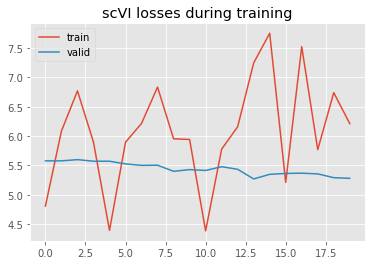

In [33]:
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.title('scVI losses during training')
plt.show()

# NMF

In [39]:
# MODEL
temp = 0.9
N = expression_train.shape[0]

U = Gamma(2. * tf.ones([N, D]), 1./2. * tf.ones([N, D]))
V = Gamma(2. * tf.ones([D, M]), 1./2. * tf.ones([D, M]))

H = RelaxedBernoulli(temperature=temp, probs=p * tf.ones([N, M]))
Y = Poisson(rate=tf.matmul(U, V) * (1. - tf.cast(H, tf.float32)))

In [40]:
# INFERENCE
qU = TransformedDistribution(
    distribution=Normal(tf.Variable(tf.ones([N, D])), tf.nn.softplus(tf.Variable(0.01 * tf.ones([N, D])))),
    bijector=tf.contrib.distributions.bijectors.Exp())

qV = TransformedDistribution(
    distribution=Normal(tf.Variable(tf.ones([D, M])), tf.nn.softplus(tf.Variable(0.01 * tf.ones([D, M])))),
    bijector=tf.contrib.distributions.bijectors.Exp())

inference = ed.KLqp({U: qU, V: qV}, data={Y: expression_train})
inference.initialize()

tf.global_variables_initializer().run()

loss = np.empty(inference.n_iter)
for i in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    loss[i] = info_dict["loss"]

inference.finalize()

/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 2779.943


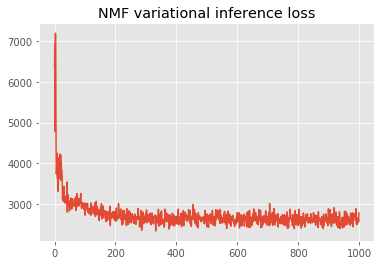

In [41]:
plt.plot(loss)
plt.title('NMF variational inference loss')
plt.show()

In [42]:
est_V = np.exp(qV.distribution.loc.eval())
est_U = np.exp(qU.distribution.loc.eval())

# Clustering

We can here sample fron the latent space, you can verify that the clustering metrics are robust with respect to different samples from the variational posterior

In [35]:
# Encode the data
latent = sess.run(model.z, feed_dict={x: expression_train})
pca_latent = PCA(n_components=2).fit_transform(expression_train)

In [43]:
# Evaluate clusters in latent space: the higher the silhouette, the 
# better the classes are separated
lat_silh = silhouette_score(latent, c_train)
nmf_silh = silhouette_score(est_U, c_train)
pca_silh = silhouette_score(pca_latent, c_train)

scores = {'scVI': lat_silh, 'NMF': nmf_silh, 'PCA': pca_silh}
max_key = max(scores, key=scores.get)

print('Silhouette scores (higher is better):')
for key in scores:
    if key == max_key: print('\033[1m', end="")
    print('- ' + key + ': %0.3f' % scores[key] + '\033[0m')

Silhouette scores (higher is better):
- PCA: 0.059
- NMF: 0.044
- scVI: 0.011


# Visualization

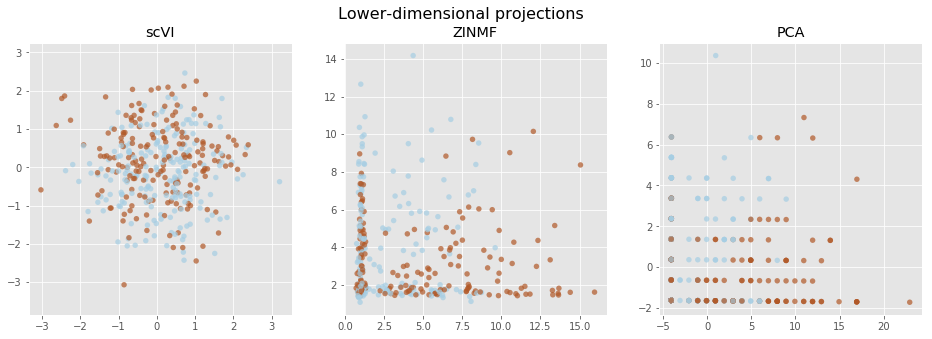

In [111]:
s = 30 
alpha = 0.7

fig = plt.figure(figsize=(16,5))
plt.suptitle('Lower-dimensional projections', fontsize=16)

plt.subplot(1, 3, 1)
plt.axis('equal')
if latent.shape[1] > 2:
    latent = TSNE().fit_transform(latent)
    plt.axis("off") # axis don't matter for a t-SNE plot
plt.scatter(latent[:, 0], latent[:, 1], c=c_train,
                    cmap=plt.get_cmap("Paired", 2), edgecolors='none', s=s, alpha=alpha)
plt.title('scVI')

plt.subplot(1, 3, 2)
plt.scatter(est_U[:, 0], est_U[:, 1], c=c_train,
                    cmap=plt.get_cmap("Paired", 2), edgecolors='none', s=s, alpha=alpha)
plt.title('ZINMF')

plt.subplot(1, 3, 3)
plt.scatter(pca_latent[:, 0], pca_latent[:, 1], c=c_train,
                    cmap=plt.get_cmap("Paired", 2), edgecolors='none', s=s, alpha=alpha)
plt.title('PCA')

plt.show()

# Imputation

We now turn to the imputation result. For that, we need to recomplete scVI's inference on corrupted data. That means clearing the computation graph of TensorFlow and starting with a new one. We corrupt the data by uniform sampling over the non-zero entries (10%)

In [17]:
# Corrupt the data with zeros at known positions according to ZIFA
X_zero, i, j, ix = dropout(expression_train, decay=0.2)

In [18]:
print('Zero proportion in original data set:')
print(1 - np.count_nonzero(expression_train) / expression_train.size)

Zero proportion in original data set:
0.28890352488995164


In [19]:
print('Zero proportion in corrupted data set:')
print(1 - np.count_nonzero(X_zero) / X_zero.size)

Zero proportion in corrupted data set:
0.3600130133139884


In [20]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')

model = scVI(x, n_hidden=15)

# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
train_loss, valid_loss = train_model(100, X_zero, expression_test)

0.0
Train / Validation performance: 29294.285 35711.367
1.0
Train / Validation performance: 31177.51 35405.797
2.0
Train / Validation performance: 27449.932 33908.16
3.0
Train / Validation performance: 28198.807 32353.617
4.0
Train / Validation performance: 29839.105 31915.73
5.0
Train / Validation performance: 30838.994 31773.207
6.0
Train / Validation performance: 27949.602 31802.896
7.0
Train / Validation performance: 29691.074 31448.664
8.0
Train / Validation performance: 29426.63 31273.654
9.0
Train / Validation performance: 27701.387 31125.434
10.0
Train / Validation performance: 25417.512 30969.514
11.0
Train / Validation performance: 28265.215 30899.486
12.0
Train / Validation performance: 30988.72 30731.148
13.0
Train / Validation performance: 29250.975 30602.76
14.0
Train / Validation performance: 25285.06 30455.486
15.0
Train / Validation performance: 30168.46 30393.605
16.0
Train / Validation performance: 28712.29 30216.402
17.0
Train / Validation performance: 27344.252 301

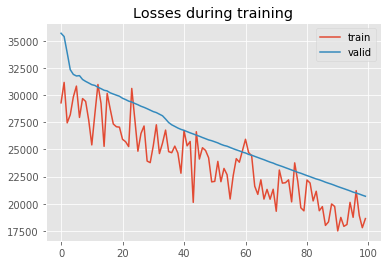

In [22]:
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.title('Losses during training')
plt.show()

In [23]:
# Get Poisson means for zeroed out points
rate_ = sess.run(model.px_rate, {x: X_zero} )

# Compute the imputation error at zeroed out points
imputation_error(rate_, expression_train, X_zero, i, j, ix)

6.997849214589223